In [1]:
# Pandas and numpy for analysing and preparing data
import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None) # display all columns of a df inline
pd.set_option('display.max_rows', None) # display all rows of a df inline
import numpy as np

# GeoPandas for handling GeoJSON
import geopandas as gpd

# Matplotlib colors
import matplotlib.cm as cm
import matplotlib.colors as colors

# Seaborn and Matplotlib for plotting data
import matplotlib.pyplot as plt
import seaborn as sns

# Handling URL queries
import json
import requests

# Folium and geopy handle and display geospatial data
import folium # display data on interactive map
from geopy.geocoders import Nominatim # get langitude and longitude for an address

# Import BeautifulSoup for scraping table from wiki-page
from bs4 import BeautifulSoup

# To cluster neighborhoods
from sklearn.cluster import KMeans

# Read environment variables with foursquare API credentials
import os

# Get data for neighborhoods in Duesseldorf

https://public.opendatasoft.com provides data on the borders of the neighborhoods, as well as on the population.

In [2]:
# Download GeoJSON for geo coordinates of neighborhoods in Duesseldorf
!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Stadtteile_WGS84_4326.geojson' -O dus_neighborhoods.geojson

# Download GeoJSON for geo coordinates of residential areas in Duesseldorf
!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Wohnquartiere_Duesseldorf_WGS84_4326.geojson' -O dus_residential_areas.geojson

# Download JSON with movements into the areas (2017)
# Description of Data: https://opendata.duesseldorf.de/dataset/bev%C3%B6lkerungswanderung-den-wohnquartieren-d%C3%BCsseldorf
!wget --quiet 'https://opendata.duesseldorf.de/api/action/datastore/search.json?resource_id=1564e254-213c-4b35-a1a9-b0e8a070ced0&limit=400' -O dus_move_in.json

# Download JSON with movements out of the areas (2017)
# Description of Data: https://opendata.duesseldorf.de/dataset/bev%C3%B6lkerungswanderung-den-wohnquartieren-d%C3%BCsseldorf
!wget --quiet 'https://opendata.duesseldorf.de/api/action/datastore/search.json?resource_id=b7f96ca0-735d-4c9b-862c-99813429e0cd&limit=400' -O dus_move_out.json

# Download CSV (JSON file was not available) with total size of population per neighborhood in Duesseldorf (2012 - 2018)
# Description of Data: https://opendata.duesseldorf.de/dataset/einwohnerzahl-d%C3%BCsseldorf-seit-2012-einwohnermeldedaten
!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Bev%C3%B6lkerungsstand%20in%20den%20Stadtteilen%20seit%202012_0.csv' -O dus_population.csv

CalledProcessError: Command 'b"\n# Download GeoJSON for geo coordinates of neighborhoods in Duesseldorf\n!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Stadtteile_WGS84_4326.geojson' -O dus_neighborhoods.geojson\n\n# Download GeoJSON for geo coordinates of residential areas in Duesseldorf\n!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Wohnquartiere_Duesseldorf_WGS84_4326.geojson' -O dus_residential_areas.geojson\n\n# Download JSON with movements into the areas (2017)\n# Description of Data: https://opendata.duesseldorf.de/dataset/bev%C3%B6lkerungswanderung-den-wohnquartieren-d%C3%BCsseldorf\n!wget --quiet 'https://opendata.duesseldorf.de/api/action/datastore/search.json?resource_id=1564e254-213c-4b35-a1a9-b0e8a070ced0&limit=400' -O dus_move_in.json\n\n# Download JSON with movements out of the areas (2017)\n# Description of Data: https://opendata.duesseldorf.de/dataset/bev%C3%B6lkerungswanderung-den-wohnquartieren-d%C3%BCsseldorf\n!wget --quiet 'https://opendata.duesseldorf.de/api/action/datastore/search.json?resource_id=b7f96ca0-735d-4c9b-862c-99813429e0cd&limit=400' -O dus_move_out.json\n\n# Download CSV (JSON file was not available) with total size of population per neighborhood in Duesseldorf (2012 - 2018)\n# Description of Data: https://opendata.duesseldorf.de/dataset/einwohnerzahl-d%C3%BCsseldorf-seit-2012-einwohnermeldedaten\n!wget --quiet 'https://opendata.duesseldorf.de/sites/default/files/Bev%C3%B6lkerungsstand%20in%20den%20Stadtteilen%20seit%202012_0.csv' -O dus_population.csv\n"' returned non-zero exit status 1.

## Extract ID, name and geometry of each neighborhood

In [3]:
neighborhoods_orig = gpd.read_file('dus_neighborhoods.geojson')
print(neighborhoods_orig.shape)
neighborhoods_orig.head()

(50, 6)


,Quelle,Stand,Stadtbezirk,Stadtteil,Name,geometry
0,Amt 12/2,31.12.2017,5,54,Wittlaer,"POLYGON ((6.76623 51.31355, 6.76618 51.31359, ..."
1,Amt 12/2,31.12.2017,5,55,Angermund,"POLYGON ((6.80952 51.34292, 6.80948 51.34302, ..."
2,Amt 12/2,31.12.2017,4,43,Lörick,"POLYGON ((6.74610 51.25203, 6.74602 51.25205, ..."
3,Amt 12/2,31.12.2017,4,42,Heerdt,"POLYGON ((6.73560 51.23767, 6.73522 51.23780, ..."
4,Amt 12/2,31.12.2017,4,41,Oberkassel,"POLYGON ((6.76868 51.23195, 6.76868 51.23196, ..."


In [4]:
neighborhoods = (neighborhoods_orig.drop(['Quelle', 'Stand', 'Stadtbezirk'], axis=1)
                                   .rename(columns={'Stadtteil': 'Neighborhood ID',
                                                    'Name': 'Neighborhood',
                                                    'geometry': 'Neighborhood Geometry'
                                                   })
                                   .set_index('Neighborhood ID')
                                   .rename(index=lambda x: f'{x:03d}')
                )

print(neighborhoods.shape)
neighborhoods.head()

(50, 2)


,Neighborhood,Neighborhood Geometry
Neighborhood ID,,
054,Wittlaer,"POLYGON ((6.76623 51.31355, 6.76618 51.31359, ..."
055,Angermund,"POLYGON ((6.80952 51.34292, 6.80948 51.34302, ..."
043,Lörick,"POLYGON ((6.74610 51.25203, 6.74602 51.25205, ..."
042,Heerdt,"POLYGON ((6.73560 51.23767, 6.73522 51.23780, ..."
041,Oberkassel,"POLYGON ((6.76868 51.23195, 6.76868 51.23196, ..."


## Extract ID, name and geometry of each residential area

In [5]:
residentials_orig = gpd.read_file('dus_residential_areas.geojson')
print(residentials_orig.shape)
residentials_orig.head()

(373, 10)


,Stand,STADTBEZIR,STADTTEIL,NAME,FLAECHE,QUARTIER,QUARTIERID,wq_typ,wq_typ_txt,geometry
0,01.01.2017,10,101,Garath,209136.4219,001,101001,1,Einfamilienhausgebiet,"POLYGON ((6.89133 51.15247, 6.89116 51.15306, ..."
1,01.01.2017,10,101,Garath,235757.3594,002,101002,3,Gemischte Bautypologie vor 1970,"POLYGON ((6.90024 51.15157, 6.90020 51.15158, ..."
2,01.01.2017,10,101,Garath,161858.3281,003,101003,3,Gemischte Bautypologie vor 1970,"POLYGON ((6.89141 51.14165, 6.89150 51.14175, ..."
3,01.01.2017,10,101,Garath,507920.5313,004,101004,3,Gemischte Bautypologie vor 1970,"POLYGON ((6.89008 51.15150, 6.88966 51.15131, ..."
4,01.01.2017,10,101,Garath,254522.9688,005,101005,3,Gemischte Bautypologie vor 1970,"POLYGON ((6.89499 51.14917, 6.89133 51.15247, ..."


In [6]:
residentials = (residentials_orig.drop(['Stand', 'STADTBEZIR', 'NAME', 'QUARTIER'], axis=1)
                                   .rename(columns={'STADTTEIL': 'Neighborhood ID',
                                                    'FLAECHE': 'Residential Area Size',
                                                    'QUARTIERID': 'Residential Area ID',
                                                    'wq_typ': 'Area Type ID',
                                                    'wq_typ_txt': 'Area Type',
                                                    'geometry': 'Area Geometry'
                                                   })
                                   .set_index('Neighborhood ID')
                                   .rename(index=lambda x: f'{int(x):03d}')
                )

print(residentials.shape)
residentials.head()

(373, 5)


,Residential Area Size,Residential Area ID,Area Type ID,Area Type,Area Geometry
Neighborhood ID,,,,,
101,209136.4219,101001,1,Einfamilienhausgebiet,"POLYGON ((6.89133 51.15247, 6.89116 51.15306, ..."
101,235757.3594,101002,3,Gemischte Bautypologie vor 1970,"POLYGON ((6.90024 51.15157, 6.90020 51.15158, ..."
101,161858.3281,101003,3,Gemischte Bautypologie vor 1970,"POLYGON ((6.89141 51.14165, 6.89150 51.14175, ..."
101,507920.5313,101004,3,Gemischte Bautypologie vor 1970,"POLYGON ((6.89008 51.15150, 6.88966 51.15131, ..."
101,254522.9688,101005,3,Gemischte Bautypologie vor 1970,"POLYGON ((6.89499 51.14917, 6.89133 51.15247, ..."


## Import total population

In [7]:
names = ['Neighborhood ID', 'Neighborhood'] + [str(x) for x in range(2012, 2019)]
population_import = pd.read_csv('dus_population.csv', sep=';', header=0, names=names)
population = pd.DataFrame({'Neighborhood ID': population_import["Neighborhood ID"].map(lambda x: f'{x:03d}'),
                           'Population': population_import['2017']}
                         ).set_index('Neighborhood ID')
print(population.shape)
population.head()

(50, 1)


,Population
Neighborhood ID,
011,2358
012,2279
013,14840
014,32626
015,20651


### Analyse Data

#### Relation between Residential Areas and Neighborhoods

In [8]:
residentials.reset_index(drop=False)[['Neighborhood ID', 'Residential Area ID']].head()

,Neighborhood ID,Residential Area ID
0,101,101001
1,101,101002
2,101,101003
3,101,101004
4,101,101005


**Finding:** A residential area can be located across multiple neighborhoods.

#### Area Types

## Extract data for movements in and out of the residential areas

In [9]:
with open('dus_move_in.json', 'r') as f:
    json_decode = json.load(f)
    
move_in_orig = json_normalize(json_decode['result']['records'])
move_in = (move_in_orig.rename(columns={'Wohnquartier': 'Residential Area ID'})
                       .set_index('Residential Area ID')
                       .fillna(value='0')
                       .astype('int64')
                       .assign(Total=lambda x: x.sum(axis=1))
          )

print(move_in.shape)
move_in.head()

(373, 9)


,Zuzüge unter 6 Jahren,Zuzüge 6 bis unter 10 Jahren,Zuzüge 10 bis unter 18 Jahren,Zuzüge 18 bis unter 25 Jahren,Zuzüge 25 bis unter 30 Jahren,Zuzüge 30 bis unter 50 Jahren,Zuzüge 50 bis unter 65 Jahren,Zuzüge 65 und mehr Jahren,Total
Residential Area ID,,,,,,,,,
11001,27,11,21,111,123,206,73,72,644
11002,0,0,0,0,0,0,0,0,0
12001,25,12,8,80,75,136,28,8,372
12002,0,0,0,0,0,0,0,0,0
13001,0,0,0,0,0,0,0,0,0


In [10]:
with open('dus_move_out.json', 'r') as f:
    json_decode = json.load(f)
    
move_out_orig = json_normalize(json_decode['result']['records'])
move_out = (move_out_orig.rename(columns={'Wohnquartier': 'Residential Area ID'})
                         .set_index('Residential Area ID')
                         .fillna(value='0')
                         .astype('int64')
                         .assign(Total=lambda x: x.sum(axis=1))
          )

print(move_out.shape)
move_out.head()

(373, 9)


,Fortzüge unter 6 Jahren,Fortzüge 6 bis unter 10 Jahren,Fortzüge 10 bis unter 18 Jahren,Fortzüge 18 bis unter 25 Jahren,Fortzüge 25 bis unter 30 Jahren,Fortzüge 30 bis unter 50 Jahren,Fortzüge 50 bis unter 65 Jahren,Fortzüge 65 Jahre und älter,Total
Residential Area ID,,,,,,,,,
11001,24,12,16,66,104,215,36,28,501
11002,0,0,0,0,0,0,0,0,0
12001,66,32,56,117,96,235,45,34,681
12002,0,0,0,0,0,0,0,0,0
13001,0,0,0,0,0,0,0,0,0


In [11]:
moves = (move_in[['Total']].join(move_out[['Total']], lsuffix='_In', rsuffix='_Out')
                           .assign(Total_Net=lambda x: x['Total_In'] - x['Total_Out'])
                           .rename(columns={'Total_In': 'Moving In',
                                            'Total_Out': 'Moving Out',
                                            'Total_Net': 'Movings'
                                           })
        )

print(moves.shape)
moves.head()

(373, 3)


,Moving In,Moving Out,Movings
Residential Area ID,,,
11001,644,501,143
11002,0,0,0
12001,372,681,-309
12002,0,0,0
13001,0,0,0


## Merge data

In [12]:
dus_data_full = (neighborhoods.join(residentials)
                              .reset_index(drop=False)
                              .merge(moves, how='inner', left_on='Residential Area ID', right_on='Residential Area ID')
                )

dus_data_full.head()

,Neighborhood ID,Neighborhood,Neighborhood Geometry,Residential Area Size,Residential Area ID,Area Type ID,Area Type,Area Geometry,Moving In,Moving Out,Movings
0,011,Altstadt,"POLYGON ((6.77727 51.23037, 6.77726 51.23047, ...",325257.3281,11001,7,Geschosswohnungsbaugebiete (versch. Baualter),"POLYGON ((6.77035 51.22534, 6.77044 51.22533, ...",644,501,143
1,011,Altstadt,"POLYGON ((6.77727 51.23037, 6.77726 51.23047, ...",120219.9531,11002,9,Freiraum,"POLYGON ((6.77153 51.23150, 6.77136 51.23150, ...",0,0,0
2,012,Carlstadt,"POLYGON ((6.77569 51.22498, 6.77563 51.22501, ...",311189.7188,12001,7,Geschosswohnungsbaugebiete (versch. Baualter),"POLYGON ((6.76768 51.21919, 6.76769 51.21919, ...",372,681,-309
3,012,Carlstadt,"POLYGON ((6.77569 51.22498, 6.77563 51.22501, ...",143192.4844,12002,9,Freiraum,"POLYGON ((6.77035 51.22534, 6.77032 51.22535, ...",0,0,0
4,013,Stadtmitte,"POLYGON ((6.79958 51.22495, 6.79956 51.22496, ...",516954.9844,13001,8,Gewerbe/Einzelhandel,"POLYGON ((6.78124 51.22863, 6.78091 51.23018, ...",0,0,0


In [13]:
dus_data = (dus_data_full.pivot_table(index=['Neighborhood ID', 'Neighborhood'], values=['Moving In', 'Moving Out', 'Movings'], aggfunc=np.sum)
                         .reset_index(drop=False)
                         .merge(population, how='inner', on='Neighborhood ID')
                         .merge(neighborhoods['Neighborhood Geometry'], how='inner', on='Neighborhood ID')
           )

print(type(dus_data))
print(dus_data.shape)
dus_data.head()

<class 'pandas.core.frame.DataFrame'>
(50, 7)


,Neighborhood ID,Neighborhood,Moving In,Moving Out,Movings,Population,Neighborhood Geometry
0,011,Altstadt,644,501,143,2358,"POLYGON ((6.77727 51.23037, 6.77726 51.23047, ..."
1,012,Carlstadt,372,681,-309,2279,"POLYGON ((6.77569 51.22498, 6.77563 51.22501, ..."
2,013,Stadtmitte,3720,3948,-228,14840,"POLYGON ((6.79958 51.22495, 6.79956 51.22496, ..."
3,014,Pempelfort,5940,5385,555,32626,"POLYGON ((6.79800 51.23008, 6.79800 51.23009, ..."
4,015,Derendorf,3094,2891,203,20651,"POLYGON ((6.79620 51.24362, 6.79618 51.24368, ..."


Create GeoDataFrame for neighborhood data

In [14]:
dus_data_geo = (gpd.GeoDataFrame(dus_data, geometry='Neighborhood Geometry')
                   .assign(Latitude=lambda x: x['Neighborhood Geometry'].map(lambda x: x.centroid.y))
                   .assign(Longitude=lambda x: x['Neighborhood Geometry'].map(lambda x: x.centroid.x))
               )

print(type(dus_data_geo))
print(dus_data_geo.shape)
dus_data_geo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(50, 9)


,Neighborhood ID,Neighborhood,Moving In,Moving Out,Movings,Population,Neighborhood Geometry,Latitude,Longitude
0,011,Altstadt,644,501,143,2358,"POLYGON ((6.77727 51.23037, 6.77726 51.23047, ...",51.228143,6.772752
1,012,Carlstadt,372,681,-309,2279,"POLYGON ((6.77569 51.22498, 6.77563 51.22501, ...",51.221887,6.770316
2,013,Stadtmitte,3720,3948,-228,14840,"POLYGON ((6.79958 51.22495, 6.79956 51.22496, ...",51.223960,6.787155
3,014,Pempelfort,5940,5385,555,32626,"POLYGON ((6.79800 51.23008, 6.79800 51.23009, ...",51.235780,6.784435
4,015,Derendorf,3094,2891,203,20651,"POLYGON ((6.79620 51.24362, 6.79618 51.24368, ...",51.253922,6.781928


## Visual Data Analysis

### Graphs

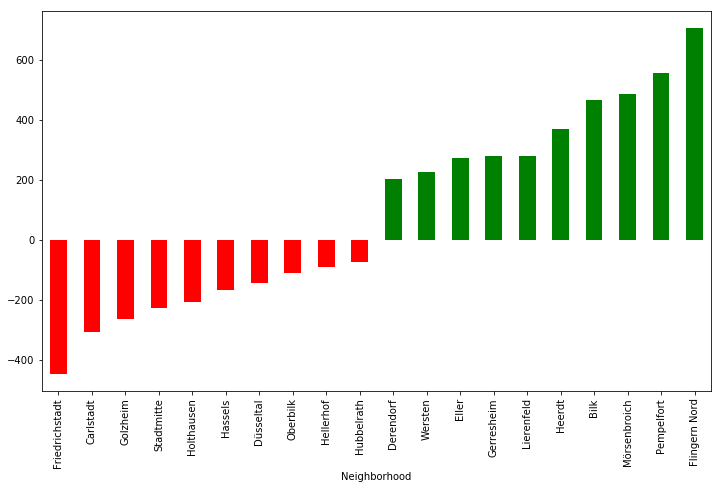

In [15]:
top = 10
top_bottom = np.r_[0:top, -top:0]

dus_top_bottom = dus_data.sort_values(by='Movings', ascending=True).iloc[top_bottom]
pos_neg = (dus_top_bottom['Movings'] > 0).map({True: 'g', False: 'r'})

fig = plt.figure(figsize=(12,7))
ax0 = fig.add_subplot(111)
dus_top_bottom.plot(kind='bar',
                    x='Neighborhood',
                    y='Movings',
                    legend=False,
                    color=pos_neg,
                    ax=ax0
                   );

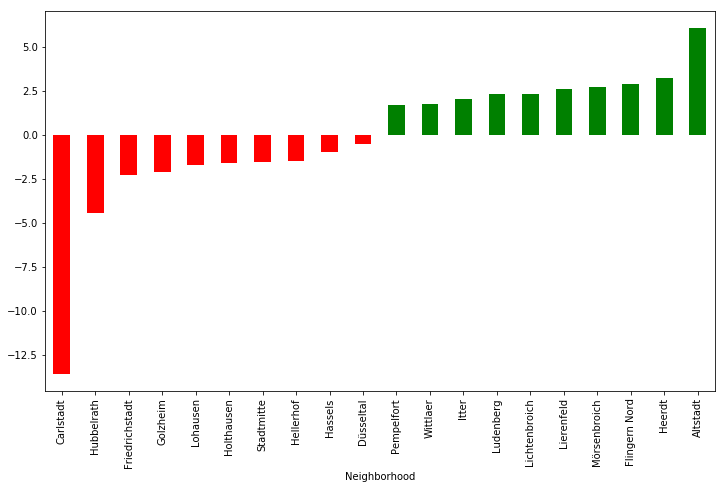

In [16]:
top = 10
top_bottom = np.r_[0:top, -top:0]

dus_top_bottom = (dus_data.assign(MovingsPerc=lambda x: x['Movings']/x['Population']*100)
                          .sort_values(by='MovingsPerc', ascending=True)
                          .iloc[top_bottom])
pos_neg = (dus_top_bottom['MovingsPerc'] > 0).map({True: 'g', False: 'r'})

fig = plt.figure(figsize=(12,7))
ax0 = fig.add_subplot(111)
dus_top_bottom.plot(kind='bar',
                    x='Neighborhood',
                    y='MovingsPerc',
                    legend=False,
                    color=pos_neg,
                    ax=ax0
                   );

## Venues

### Build category hierarchy

#### Pull categories from foursquare API as JSON and extract categories

In [17]:
url = 'https://api.foursquare.com/v2/venues/categories'
params = dict(client_id=os.getenv('FS_CLIENT_ID'),
              client_secret=os.getenv('FS_CLIENT_SECRET'),
              v='20190106'
             )

results = requests.get(url=url, params=params).json()['response']['categories']

In [18]:
def extract_rows(category, new_data, next_level, level):
    
    if len(category['categories']) > 0:
        new_data.extend([{f'{level}_ID': category['id'],
                          f'{level}': category['shortName'],
                          f'{level}_SUB_ID': sub_cat['id']} for sub_cat in category['categories']
                        ])
        next_level.extend(category['categories'])
    else:
        new_data.append({f'{level}_ID': category['id'],
                         f'{level}': category['shortName'],
                         f'{level}_SUB_ID': np.nan
                        })
    
    return (new_data, next_level)

In [19]:
def expand_df(df, df_new_data, level):
    
    if level == 1:
        df = df_new_data
    else:
        df = df.merge(df_new_data,
                      how='left',
                      left_on=df.columns[-1],
                      right_on=df_new_data.columns[0]
                     )
    
    return df

In [20]:
def extract_categories(data, level, df=pd.DataFrame()):
    
    new_data = []
    next_level = []
    for category in data:
        new_data, next_level = extract_rows(category, new_data, next_level, level)
    
    df_new_data = pd.DataFrame([row for row in new_data])
    df = expand_df(df, df_new_data, level)
    
    if len(next_level) > 0:
        df = extract_categories(next_level, (level+1), df)
    
    columns_to_drop = df.columns[df.columns.str.contains('SUB_ID')]
    df = df.drop(columns_to_drop, axis=1)
    
    return df


In [21]:
start_level = 1

foursquare_cat = extract_categories(results, start_level)

print(foursquare_cat.shape)
foursquare_cat.head()

(865, 10)


,1_ID,1,2_ID,2,3_ID,3,4_ID,4,5_ID,5
0,4d4b7104d754a06370d81259,Arts & Entertainment,56aa371be4b08b9a8d5734db,Amphitheater,NaN,NaN,NaN,NaN,NaN,NaN
1,4d4b7104d754a06370d81259,Arts & Entertainment,4fceea171983d5d06c3e9823,Aquarium,NaN,NaN,NaN,NaN,NaN,NaN
2,4d4b7104d754a06370d81259,Arts & Entertainment,4bf58dd8d48988d1e1931735,Arcade,NaN,NaN,NaN,NaN,NaN,NaN
3,4d4b7104d754a06370d81259,Arts & Entertainment,4bf58dd8d48988d1e2931735,Art Gallery,NaN,NaN,NaN,NaN,NaN,NaN
4,4d4b7104d754a06370d81259,Arts & Entertainment,4bf58dd8d48988d1e4931735,Bowling Alley,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
columns = foursquare_cat.columns[~foursquare_cat.columns.str.contains('_ID')]
print('Number of categories per category level:')
print('\n'.join([f'Level {x}: {len(foursquare_cat[x].unique())}' for x in columns]))

Number of categories per category level:
Level 1: 10
Level 2: 450
Level 3: 360
Level 4: 92
Level 5: 14


Not all level 2 categories also have a level 3 category. Therefore assign all categories to level 2, as all venues can be categorized on this level.

#### Create dictionary to look up Category LVL of a Category ID

In [23]:
def create_lvl_dict(df):
    
    levels_dict = {}
    
    lvl = len(df.columns) // 2
    levels = [str(i) for i in range(1, (lvl+1))]
    for level in levels:
        column = f'{level}_ID'
        cat_id = list(df[column][df[column].notnull()].unique())
        lvl_list = [level] * len(cat_id)
        levels_dict.update(dict(zip(cat_id, lvl_list)))
    
    return levels_dict
        

In [24]:
cat_lvl = create_lvl_dict(foursquare_cat)

### Create list of venues per neighborhood

#### Get list of venus via Foursquare API

In [ ]:
# Build one DataFrame with top venues per neighborhood
def getNearbyVenues(neighborhoods, latitudes, longitudes, radius=500):
    
    venues_list = []
    # Iterate through list of neighborhoods
    for neighborhood, lat, lng in zip(neighborhoods, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(client_id=os.getenv('FS_CLIENT_ID'),
                      client_secret=os.getenv('FS_CLIENT_SECRET'),
                      v='20190106',
                      ll=f'{lat},{lng}',
                      radius=radius,
                      limit=100
                     )

        # make the GET request
        results = requests.get(url=url, params=params).json()
        try:
            results = results['response']['groups'][0]['items']

        except:
            print('Something went wrong with the query. Here are some information:')
            print(f'Neighborhood: {neighborhood}, lat,lng: {lat},{lng}')
            print(results)
        # List of list with only relevant information per venue
        # Multiple entries per venue, if multiple categories have been assigned
        for v in results: 
            venues_list.append([(neighborhood,
                                 lat,
                                 lng,
                                 v['venue']['name'],
                                 v['venue']['location']['lat'],
                                 v['venue']['location']['lng'],
                                 n['id']) for n in v['venue']['categories']]
                              )

        # Create DataFrame
        columns = ['Neighborhood ID', 'Neighborhood Latitude', 'Neighborhood Longitude',
                   'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category ID']
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = columns
        nearby_venues.set_index('Neighborhood ID')
    
    return nearby_venues

In [ ]:
# Create DataFrame with one row per venue returned matching the neighborhood it belongs to 
dus_venues = getNearbyVenues(neighborhoods=dus_data['Neighborhood ID'],
                             latitudes = dus_data_geo['Latitude'],
                             longitudes = dus_data_geo['Longitude'],
                             radius=700
                            )

print(dus_venues.shape)
dus_venues.head()

Pickle results to continue working on the data at a later point in time.

In [ ]:
dus_venues.to_pickle('dus_venues.pkl', compression='gzip')

In [26]:
dus_venues = pd.read_pickle('dus_venues.pkl', compression='gzip')

### Combine Venue and Category information

As defined earlier target is to map all venues to a category on the second level. Before this it is required to analyse the initial category level assignments.

In [27]:
kwargs = {'Venue Category Lvl': dus_venues['Venue Category ID'].map(lambda x: cat_lvl[x])}

dus_venues_analysis = (dus_venues.assign(**kwargs))
dus_venues_analysis['Venue Category Lvl'].astype('int64').value_counts()

2    745
3    305
4     23
1      1
Name: Venue Category Lvl, dtype: int64

One venue has been assigned to category level 1 and therefore needs to be assigned manually to a category at level 2.

In [28]:
dus_venues_analysis[dus_venues_analysis['Venue Category Lvl'] == '1']

,Neighborhood ID,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category ID,Venue Category Lvl
579,031,51.214279,6.783253,Düssel,51.208952,6.785794,4d4b7105d754a06377d81259,1


The 'Düssel' is a canal in the midst of the city and thus will be assigned to this category.

In [29]:
# Get category id for category 'Canal'
canal_id = foursquare_cat['2_ID'][foursquare_cat['2'] == 'Canal'].values[0]

# Assign this category_id to venue 'Düssel'
# dus_venues.loc[dus_venues['Venue'] == 'Düssel', 'Venue Category ID'] = canal_id
dus_venues.at[579, 'Venue Category ID'] = canal_id

In [30]:
dus_venues[dus_venues['Venue'] == 'Düssel']

,Neighborhood ID,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category ID
579,031,51.214279,6.783253,Düssel,51.208952,6.785794,56aa371be4b08b9a8d573562


In [79]:
def harmonize_cat_level(cat_ids, target_lvl, cat_lvl, foursquare_cat):
    
    categories = []
    
    for cat_id in cat_ids:
        level = cat_lvl[cat_id]
        if level != target_lvl:
            cat_id = foursquare_cat.at[foursquare_cat.index[foursquare_cat[f'{level}_ID'] == cat_id][0],
                                       f'{target_lvl}_ID']
        
        category = foursquare_cat.at[foursquare_cat.index[foursquare_cat[f'{target_lvl}_ID'] == cat_id][0],
                                     target_lvl]
        categories.append(category)
    
    return categories

In [81]:
target_lvl = '2'

dus_venues['Venue Category'] = harmonize_cat_level(dus_venues['Venue Category ID'], target_lvl, cat_lvl, foursquare_cat)
dus_venues.head()

,Neighborhood ID,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category ID,Venue Category
0,011,51.228143,6.772752,Elephant Bar,51.226851,6.772636,4bf58dd8d48988d11e941735,Bar
1,011,51.228143,6.772752,Bar Chérie,51.226886,6.772424,4bf58dd8d48988d116941735,Bar
2,011,51.228143,6.772752,Kreuzherreneck,51.228895,6.773122,4bf58dd8d48988d116941735,Bar
3,011,51.228143,6.772752,Brauerei Kürzer,51.226973,6.773423,50327c8591d4c4b30a586d5d,Brewery
4,011,51.228143,6.772752,Rheintreppen,51.227463,6.770819,4bf58dd8d48988d164941735,Plaza


## Blabla 

In [ ]:
def return_top_nationalities(neighborhood, top, threshold=1):
    top += 1
    top_nationalities = (neighborhood.sort_values(ascending=False)
                                     .head(top)[1:top] # Germany is in all neighborhoods top 1 nationality, therefore drop it
                                     .index
                        )
    return top_nationalities

In [ ]:
top = 10
top_nationalities_dict = {}
nationality_t = nationality.apply(lambda x: x / x.sum(), axis=1).transpose()

for neighborhood in nationality_t:
    top_nationalities_dict[neighborhood] = return_top_nationalities(nationality_t[neighborhood], top)

columns = [str(x) for x in range(1, top + 1)]
top_nationalities = pd.DataFrame(top_nationalities_dict).transpose()
top_nationalities.columns = columns
top_nationalities.head()

In [ ]:
# Join neighborhoods and nationality data on 'Neighborhood ID' and calculate percentage of nationality per neighborhood
dus_data = neighborhoods.merge(top_nationalities,
                               how='inner',
                               left_index=True,
                               right_index=True
                              )
print(dus_data.shape)
dus_data.head()

#### Visualize data on a map

In [ ]:
dus_centre = Nominatim(user_agent='dus')
location = dus_centre.geocode(query='Unterbilk, Düsseldorf', country_codes='de')
dus_latitude = location.latitude
dus_longitude = location.longitude

print(f'The coordinates of Duesseldorf are {dus_latitude}, {dus_longitude}.')

In [ ]:
# create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

# for code, lat, lng in zip(dus_data['Postal Code'], dus_data['Latitude'], dus_data['Longitude']):
#     folium.Marker(location=[lat, lng],
#                   icon=folium.DivIcon(html=f"""<div style="color: black;">{code}</div>""")
#                  ).add_to(map_dus)

# generate choropleth map to show postal code areas
folium.GeoJson(data=dus_data[['geometry', 'Neighborhood', '1', '2', '3']],
               tooltip=folium.features.GeoJsonTooltip(['Neighborhood', '1', '2', '3'])
              ).add_to(map_dus)

map_dus

In [ ]:
# Build one DataFrame with top venues per neighborhood
def getNearbyVenues(postal_codes, names, latitudes, longitudes, radius=500):
    
    venues_list = []
    # Iterate through list of neighborhoods
    for postal_code, name, lat, lng in zip(postal_codes, names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(client_id=os.getenv('FS_CLIENT_ID'),
                      client_secret=os.getenv('FS_CLIENT_SECRET'),
                      v='20180323',
                      ll=f'{lat},{lng}',
                      radius=radius,
                      limit=100
                     )

        # make the GET request
        results = requests.get(url=url, params=params).json()
        try:
            results = results['response']['groups'][0]['items']

        except:
            print('Something went wrong with the query. Here are some information:')
            print(f'Postal Code: {postal_code}, Section: {section}')
            print(results)
        # List of list with only relevant information per venue
        # Multiple entries per venue, if multiple categories have been assigned
        for v in results: 
            venues_list.append([(postal_code,
                                 name,
                                 lat,
                                 lng,
                                 v['venue']['name'],
                                 v['venue']['location']['lat'],
                                 v['venue']['location']['lng'],
                                 n['name']) for n in v['venue']['categories']]
                              )

        # Create DataFrame
        columns = ['Postal Code', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
                   'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = columns
    
    return(nearby_venues)

In [ ]:
# Create DataFrame with one row per venue returned matching the neighborhood it belongs to 
dus_venues = getNearbyVenues(postal_codes=dus_data['Postal Code'],
                             names=dus_data['Neighborhood'],
                             latitudes=dus_data['Latitude'],
                             longitudes=dus_data['Longitude']
                            )

In [ ]:
dus_venues.head()

In [ ]:
dus_venues.to_pickle('dus_venues.pkl', compression="gzip")

In [ ]:
venue_counts = (dus_venues['Postal Code'].value_counts()
                                        .to_frame()
                                        .reset_index(drop=False)
                                        .rename(columns={'index':'Postal Code', 'Postal Code':'Venues'})
               )
venue_counts

For 35 of the 37 postal code areas, min. one venue has been returned.

In [ ]:
len(dus_venues['Postal Code'].value_counts())

In [ ]:
color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
sns.palplot(sns.color_palette(color_scale))

In [ ]:
# Create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

# for code, lat, lng in zip(dus_data['Postal Code'], dus_data['Latitude'], dus_data['Longitude']):
#     folium.Marker(location=[lat, lng],
#                   icon=folium.DivIcon(html=f"""<div style="color: black;">{code}</div>""")
#                  ).add_to(map_dus)

# Define bins for coloring
threshold_scale = list(range(0,101,20))
threshold_scale[-1] = threshold_scale[-1] + 0.1

# Generate choropleth map to show postal code areas
folium.Choropleth(
    geo_data='dus_postal_code_geo.json',
    key_on='feature.properties.plz',
    data=venue_counts,
    columns=['Postal Code', 'Venues'],
    fill_color='BuGn',
    threshold_scale=threshold_scale,
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Venues per Postal Code'
).add_to(map_dus)

map_dus

In [ ]:
dus_venues_one_hot = pd.get_dummies(dus_venues[['Postal Code', 'Venue Category']], columns=['Venue Category'])

In [ ]:
dus_venues_mean = dus_venues_one_hot.groupby(by='Postal Code').agg('mean').reset_index(drop=False)